In [ ]:
# This is a modified version of CNV_detect that takes multiple varscan .copynumber files, relative to multiple genome comparisons
# and plot the genomes linearly one under the other so that they can be easily visualized in a figure in papers

# NOTE
# The code is made available for transparency reasons. At present, it is not intended to be readily usable on different datasets. 
# Also, it was not annotated and compiled to be user-friendly. Please, contact me privately for any inquiry related to the code usage.
# I will maintain this code with improved versions as soon as they are developed.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import glob, os
import sys
#import seaborn as sns
from scipy.stats import mode
from matplotlib.patches import Rectangle
import matplotlib.colors
%matplotlib inline

s=0
y_genome = []
x_genome = []
names = []
# Find the .copynumber files in the folder and generate 3 pdf for each file
os.chdir("../Clones")

files = glob.glob("*.copynumber")
numbers = len(files)
#y_genomes = {}
#x_genomes = {}
for file in files:
    # load the varscan dataset
    datafn=file

    # Read in the start position and log2_ratio for each window, saving each chromosome separately
    # Initialize a dictionary to hold the data, arranged by chromosome
    chrom_dict = {}
    with open(datafn) as datafile:
        # The first line of the file is the header line. Store in variable `header,' which we will ignore.
        header = datafile.readline()
        # Read the file one line at a time
        for line in datafile:
            # The first position in the line gives the chromosome
            chrom = line.split()[0]
            # If we don't already have an entry for the chromosome in our dictionary, create an entry.
            # The entry consists of two empty lists, one will hold the start positions and one will hold the coverage
            if chrom not in chrom_dict:
                chrom_dict[chrom] = ([], [],[],[])
            # Store the start position, coverage_ratio,normal_depth,tumor_depth in their respective lists
            chrom_dict[chrom][0].append(int(line.split()[1]))
            chrom_dict[chrom][1].append(float(line.split()[-2]))
            chrom_dict[chrom][2].append(float(line.split()[-4]))
            chrom_dict[chrom][3].append(float(line.split()[-3]))

    genome_list_anc = []
    genome_list_evo = []

    W = 2000 #set the size of the window
    
    #store anc depth for entire genome
    #calculate the median of normal depth across the whole genome
    for value in chrom_dict.itervalues():
        genome_list_anc.extend(value[2])

    genome_array_anc = np.array(genome_list_anc)
    genome_median_anc = np.median(genome_array_anc)

    # store evo depth for entire genome
    #calculate the median of tumor depth across the whole genome
    for value in chrom_dict.itervalues():
        genome_list_evo.extend(value[3])

    genome_array_evo = np.array(genome_list_evo)
    genome_median_evo = np.median(genome_array_evo)

    # Loop over the different chromosomes, plot the coverage, and save the figure

    chrom_list = sorted(chrom_dict.keys())
    x_vals = []
    y_vals = []
    x_vals_anc = []
    y_vals_anc = []
    x_vals_evo = []
    y_vals_evo = []

    
    for chrom in chrom_list:
        # Get the start positions and coverage ratio from our dictionary.
        # Convert the data from lists to numpy arrays (better for mathematical operations and plotting)
        start = np.array(chrom_dict[chrom][0])
        cov_ratio = np.array(chrom_dict[chrom][1])
        anc_depth = np.array(chrom_dict[chrom][2])
        evo_depth = np.array(chrom_dict[chrom][3])

        # Normalize by median of genome depth to control for difference sequencing depths
        normalized_depth_anc = anc_depth / genome_median_anc
        normalized_depth_evo = evo_depth / genome_median_evo
        normalized_depth = (normalized_depth_evo) - (normalized_depth_anc) # ratio between evo and anc
        
        # Calculate smoothed coverage over different window sizes for the normalized evo genome
        
        smoothed = np.zeros((start[-1] / W) + 1)
        n_bins = np.zeros_like(smoothed)
        for i in range(len(normalized_depth)):
            smoothed[start[i]/W] += normalized_depth[i]
            n_bins[start[i]/W] += 1
        smoothed /= n_bins

        x_vals.append(W*np.arange(len(smoothed)))
        y_vals.append(smoothed)


    #get the names of the two genomes compared
    anc_text = file.partition("_vs_")[0]
    evo_text = file.partition("_vs_")[2]
    evo_name = evo_text.partition("_.")[0]
    
    names.append(evo_name)
    #calculate the log2 for the y_vals
    #for i in range(len(y_vals)): 
    #    y_vals[i]= np.log2(y_vals[i]) 
     
    y_genome.append([y for x in y_vals for y in x])
    x_vals_cum = x_vals[:]
    for i in range (1,len(x_vals)):
        x_vals_cum[i]=x_vals[i] + max(x_vals_cum[i-1])
    x_genome.append([y for x in x_vals_cum for y in x])
    s = s+1
    

    

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in divide


In [8]:
names

['EVO1_12',
 'EVO1_3',
 'EVO1_7',
 'EVO1_9',
 'EVO2_10',
 'EVO2_1',
 'EVO2_2',
 'EVO2_3',
 'EVO3_12',
 'EVO3_1',
 'EVO3_8',
 'EVO3_9',
 'EVO4_2',
 'EVO4_3',
 'EVO4_5',
 'EVO4_9',
 'EVO5_11',
 'EVO5_3',
 'EVO5_4',
 'EVO5_5',
 'EVO6_1',
 'EVO6_3',
 'EVO6_5',
 'EVO6_7',
 'EVO7_4',
 'EVO7_6',
 'EVO7_7',
 'EVO7_9',
 'EVO8_10',
 'EVO8_5',
 'EVO8_7',
 'EVO8_9']

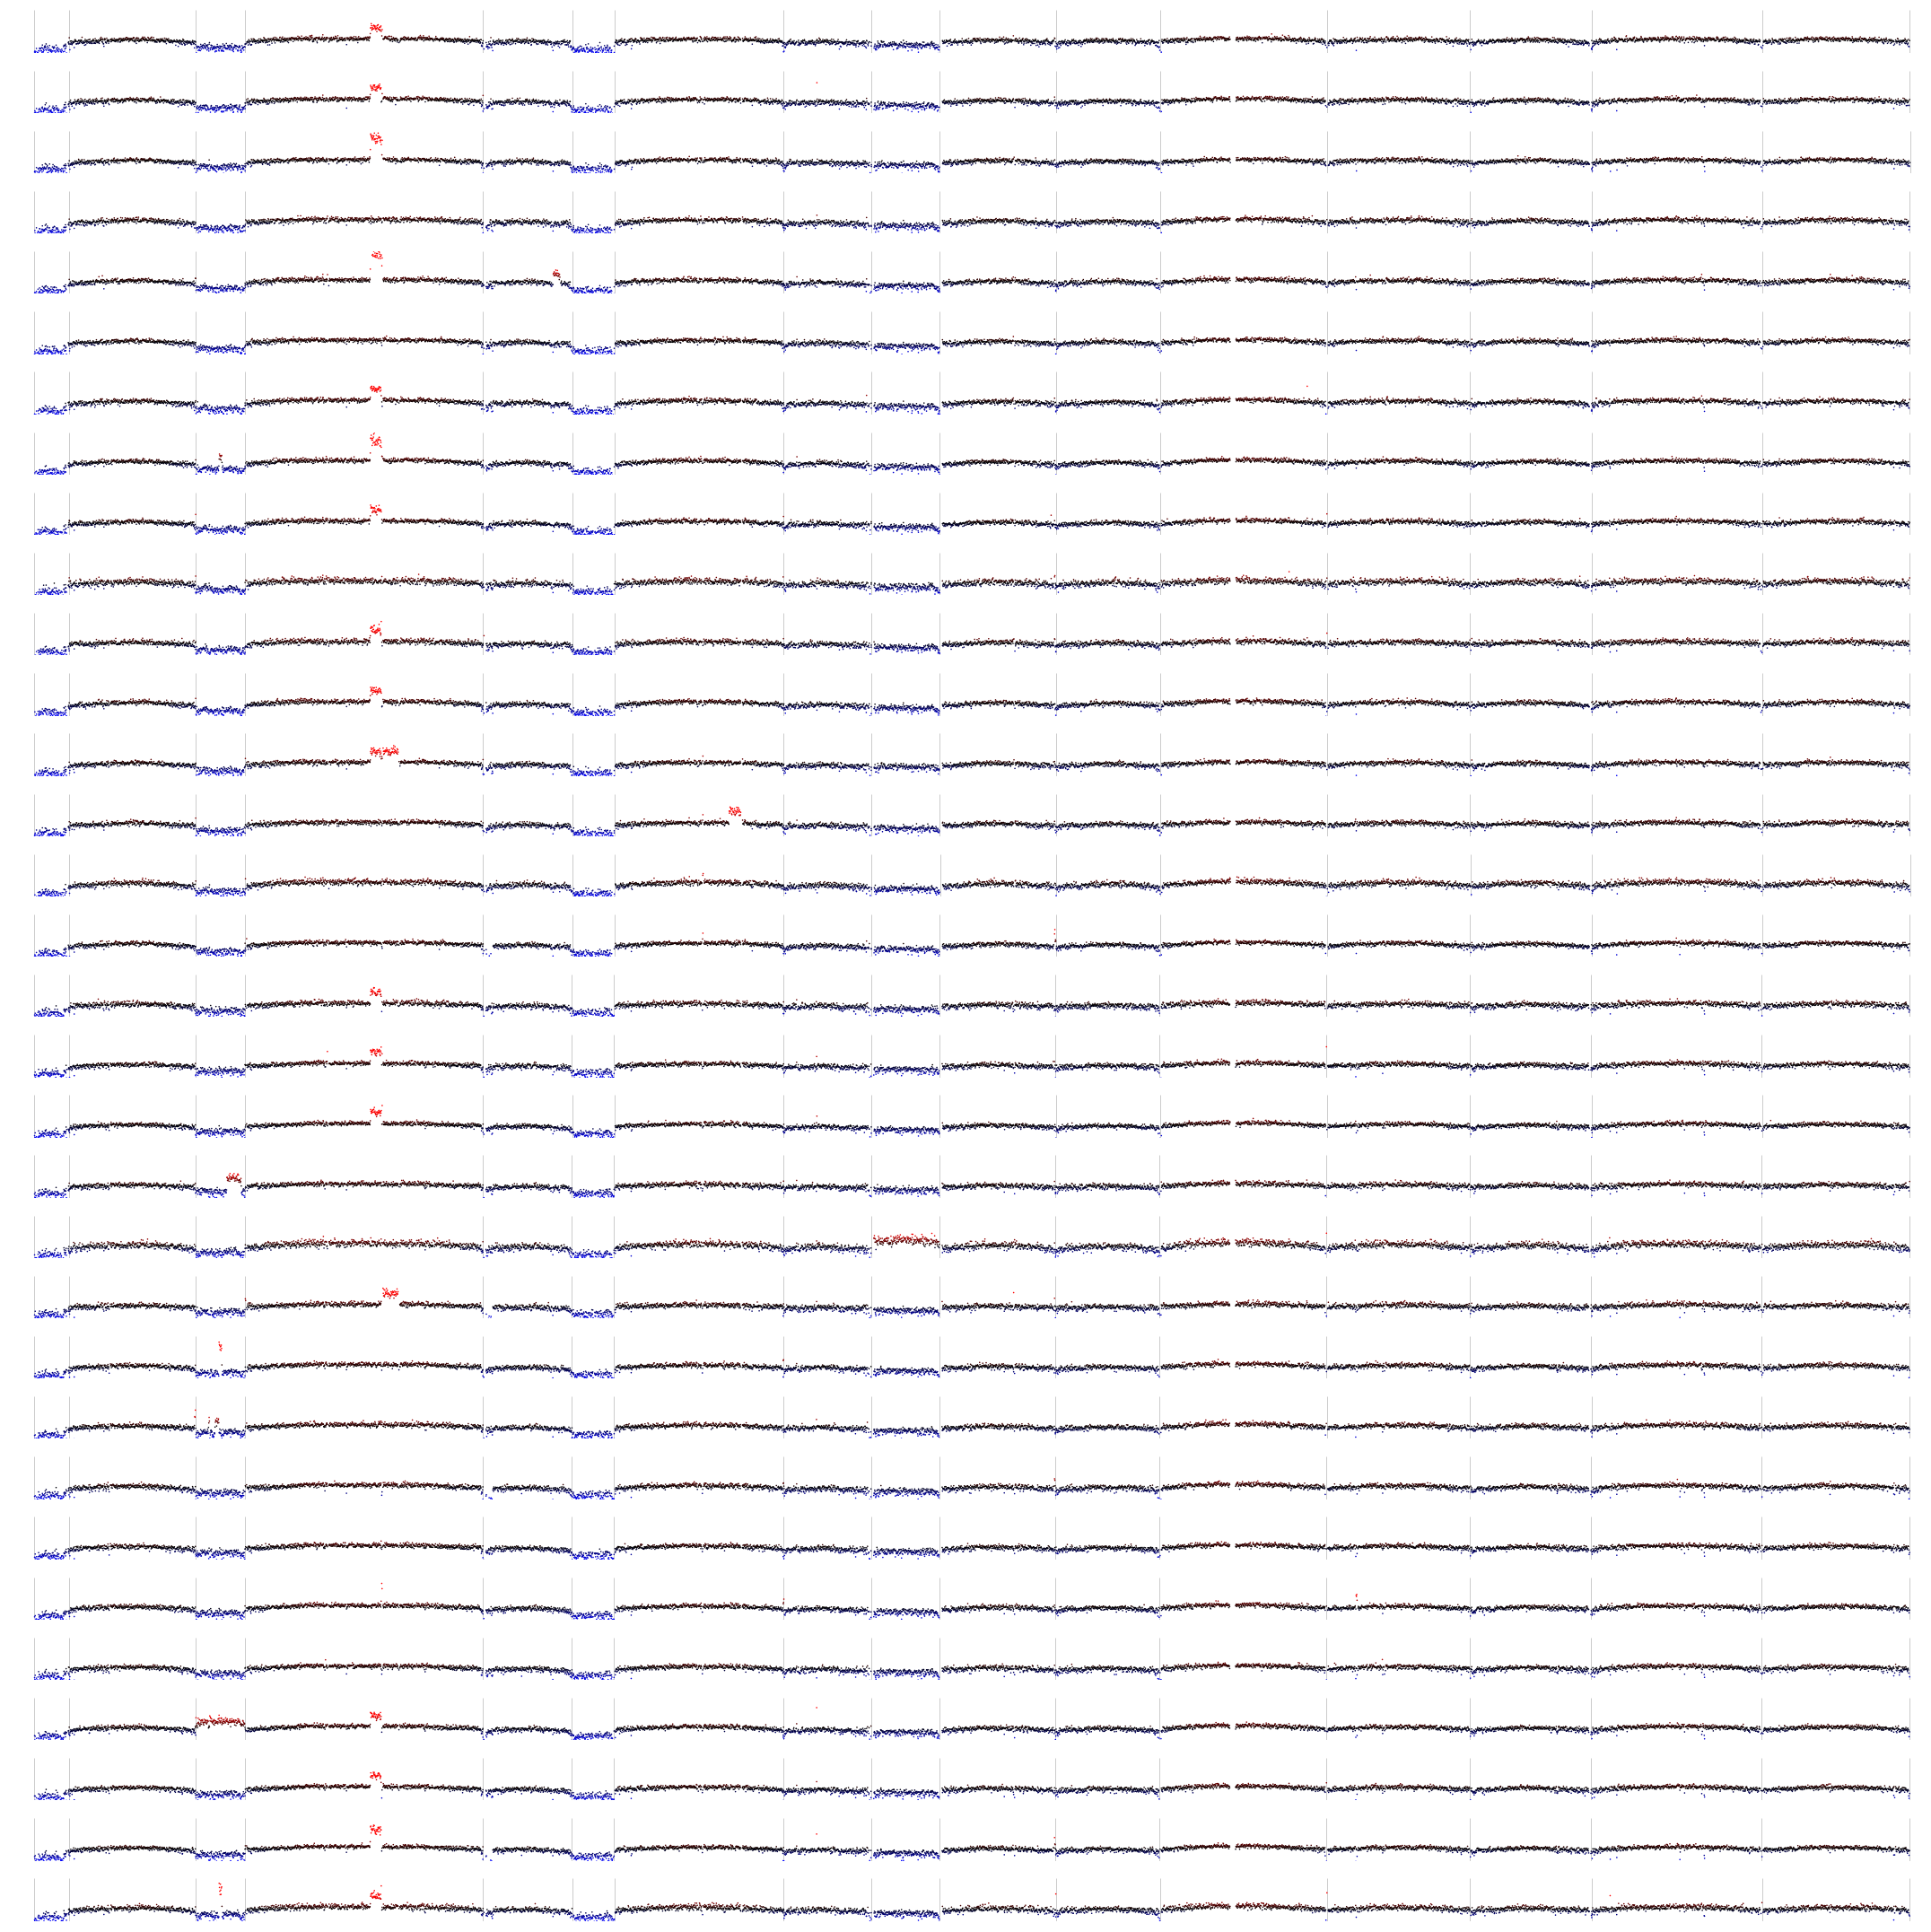

In [10]:
#Plot everything
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","black","red"])
    
fig, ax = plt.subplots(s,1, figsize=(30,30))
#fig.text(0.5, 0.01, 'chromosome coordinate', ha='center', va='center',fontsize=8)
#fig.text(0.01, 0.5, 'Log2(ratio)', ha='center', va='center', rotation='vertical',fontsize=8)
fig_fn = 'all_genomes_new2.pdf'
pdf_pages = PdfPages(fig_fn)

ymax=2.5
ymin=-1

for i, a in enumerate(ax.flatten()):
    cp= y_genome[i]
    a.axis('off')
    #a.plot(x_genome[i], y_genome[i], alpha=0.3)
    a.scatter(x_genome[i], y_genome[i], marker='.', s=10, linewidth='0', c=cp, vmin=-1, vmax=1, cmap=cmap, zorder=10)
    a.set_ylim([ymin, ymax])
    x_max=max(x_genome[i])
    #a.yaxis.set_ticks(np.arange(ymin,(ymax+0.5),0.5))
    for i in range(0,len(x_vals_cum)):
        start= min(x_vals_cum[i])
        a.vlines(start, ymin, ymax, alpha=0.2)
    a.set_xlim(-15000, x_max+15000)
    #a.set_aspect(60000)
    a.yaxis.set_tick_params(labelsize=10)
    a.set_xticklabels([])
fig.tight_layout()
pdf_pages.savefig(fig,dpi=200)
#plt.show()

#Save the pdf file
pdf_pages.close()


In [66]:
# Calculate the average copy numbers of the clones that amplified the SCC2 region
y_scc2=[]
evo_list = []
evo_amp = []
for i, g in enumerate(y_genome):
    y = np.mean(g[x1:x2:])
    y_scc2.append(y)
    evo = np.power(2, y)
    evo_list.append(evo)
    if evo > 1.5:
        evo_amp.append(evo)
np.mean(evo_amp)

2.6928148076995182

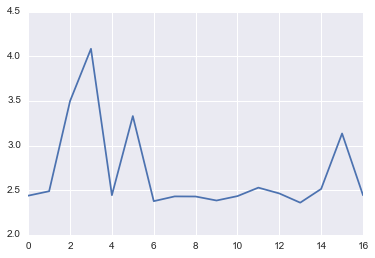

In [70]:
plt.plot(evo_amp);

In [ ]:
-